FWHM в МГЦ: 4.485004485004425
(np.float64(198695378495.37848), np.float64(0.44770028683251917))


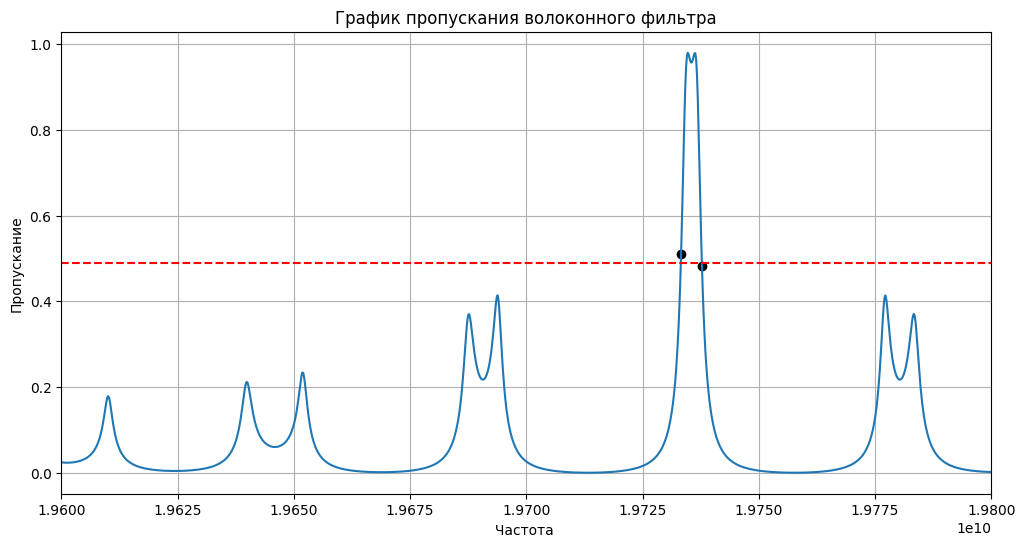

In [18]:
import math
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.signal import find_peaks
#%matplotlib qt 
freq = np.linspace(1.96e10, 1.99*10e10, 1000000)

k1 = k3 = 0.25
k2 = 0.032
l = 4.300018428650408
L = 4.914306775600466
n = 1.46
c = 3e8
T1 = n*l/c
T2 = n*L/c
α = 0.00018
γ1 = np.exp(-α * l)
γ2 = np.exp(-α * L)
N = 7
M = 8
C1 = np.sqrt(1-k1)
C2 = np.sqrt(1-k2)
C3 = np.sqrt(1-k3)
'''Здесь потери на резонансном пике кольцевого резонатора определяются как резонансные потери. \
Значение κ1 должно быть меньше 0,38 для реализации низкого перекрестного искажения менее\
−15  дБ, а κ2 можно рассчитать из соотношения k2 = k1**2/(2-k1**2), в котором κ2 является критическим коэффициентом связи, который \
минимизирует резонансные потери [15] . Частотная характеристика DRR с κ 1  = κ 3 = 0,25, κ 2 = 0,032, при сохранении других \
параметров неизменными, представлена ​​на рис. 6б , на котором вторичные пики значительно подавлены, сохраняя резонансные потери \
на аналогичном уровне по сравнению с рис. 6а . '''
def t_filter_first(w):
    z = np.exp(1j*w*2*np.pi*(T1 / N))
    return  (1j * np.sqrt(γ1 * γ2 * k1 * k2 * k3) * np.sqrt(z**(-(N + M))))/(1 - C1 * C2 * γ1 * z**(-N) - C2 * C3 * γ2 * z**(-M)\
        + C1 * C3 * γ1 * γ2 * z**(-(N + M)))
def T_filter_first(freq):
    result = []
    for w in freq:
        value = t_filter_first(w)
        result.append(value)
    return np.array(result)

T_values = np.abs(T_filter_first(freq))
T_values = T_values - np.min(T_values)
max_amplitude = np.max(T_values)
half_max_amplitude = max_amplitude / 2
# Поиск точек пересечения с половиной максимума
crossings = []
for i in range(len(T_values)):
    if (T_values[i] - half_max_amplitude) * (T_values[i-1] - half_max_amplitude) <= 0:
        crossings.append((freq[i], T_values[i]))
    if i == len(T_values)-1:
        fwhm = abs(crossings[7][0] - crossings[6][0])
        print(f"FWHM в МГЦ: {fwhm/1e6}")
    #else:
        #print("Не найдено двух пересечений с половиной максимума.")
print(max(crossings))   
# Поиск пиков
peaks, _ = find_peaks(T_values)
#print(freq[peaks])
#print(T_values[peaks])
# Определение максимального пика
#print('FSR в ГГЦ:', (freq[peaks[27]]-freq[peaks[13]])/1e9)
#print('FWHM в МГЦ:', 39.500039499644515)
# Построим график зависимости модуля пропускания от частоты
plt.figure(figsize=(12, 6))
plt.plot(freq, T_values)
plt.axhline(half_max_amplitude, color='r', linestyle='--')  # линия половины максимума
plt.scatter([c[0] for c in crossings], [c[1] for c in crossings], color='k')  # точки пересечения
plt.xlim(1.96e10, 1.98e10)
plt.xlabel('Частота ')
plt.ylabel('Пропускание')
plt.title('График пропускания волоконного фильтра')
plt.grid(True)
plt.show()

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.signal import find_peaks

df = pd.read_csv('50mks1mSA0.csv')
spectr1 = np.array(df.iloc[:,0])
spectr1 = np.linspace(1.4100E-04, 6.4100E-04, 625000)
Spectr1 = np.array(df.iloc[:,1])
dt = spectr1[1] - spectr1[0]
fft_signal = np.fft.fft(Spectr1)
fft_signal = fft_signal[:len(fft_signal)//2-1]
freq = np.fft.fftfreq(len(Spectr1), d = dt)
freq = freq[freq>0]
fft_signal_norm = abs(fft_signal)/max(abs(fft_signal))\

c= 3e8
h = 1550e-9
f_Er = c/h
freq = freq - 80e6 + c/h

def a(FSR):
    #FSR = 800e6
    n = 1.46
    l = 7 * c / (n  * FSR)
    N = 7
    M = 8
    L = M/N * l
    k1 = k3 = 0.25
    k2 = 0.032
    T1 = n*l/c
    T2 = n*L/c
    α = 0.000001
    γ1 = np.exp(-α * l)
    γ2 = np.exp(-α * L)
    C1 = np.sqrt(1-k1)
    C2 = np.sqrt(1-k2)
    C3 = np.sqrt(1-k3)
    def t_filter_first(w):
        z = np.exp(1j*w*2*np.pi*T1/N)
        return  (1j * np.sqrt(γ1 * γ2 * k1 * k2 * k3) * np.sqrt(z**(-(N + M))))/(1 - C1 * C2 * γ1 * z**(-N) - C2 * C3 * γ2 * z**(-M)\
            + C1 * C3 * γ1 * γ2 * z**(-(N + M)))
    def T_filter_first(freq):
        result = []
        for w in freq:
            value = t_filter_first(w)
            result.append(value)
        return np.array(result)
    T_values = np.abs(T_filter_first(freq))
    peaks, _ = find_peaks(T_values)
    max_peak_index = peaks[np.argmax(T_values[peaks])]
# Значение по оси x для максимального пика
    max_x_value = freq[max_peak_index]
    return max_x_value
def b(freq):
    FSR = 249.89e6
    while abs((a(FSR)  - (c/h - 14e6))) > 1e6:
        FSR-=0.001e6
    return FSR
print(b(freq)/1e6)


249.216


5.771524157291513
6.596027608333157
Пик пропускания находится в точке x = 193548.37229866988 ГГц


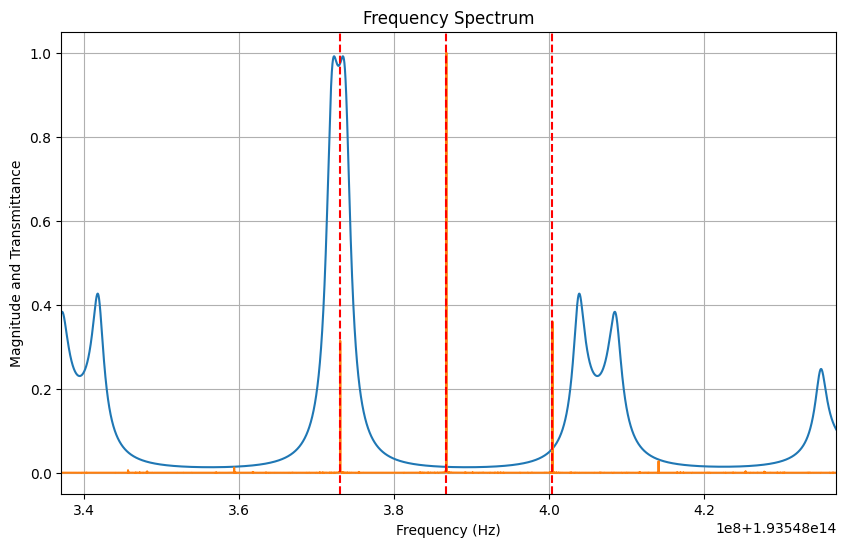

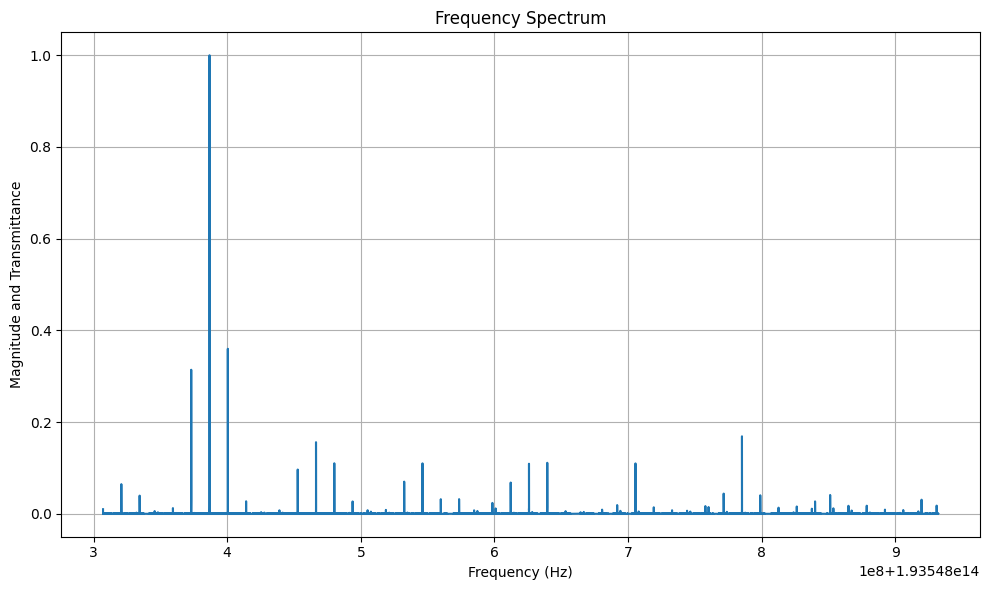

In [ ]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.signal import find_peaks
df = pd.read_csv('50mks1mSA0.csv')
#spectr1 = np.array(df.iloc[:,0])
Spectr1 = np.array(df.iloc[:,1])
spectr1 = np.linspace(1.4100E-04, 6.4100E-04, 625000)

dt = spectr1[1] - spectr1[0]
fft_signal = np.fft.fft(Spectr1)
fft_signal = fft_signal[:len(fft_signal)//2-1]
freq = np.fft.fftfreq(len(Spectr1), d = dt)
freq = freq[freq>0]
fft_signal_norm = np.abs(fft_signal)/max(abs(fft_signal))
'''peaks, _ = find_peaks(abs(fft_signal_norm)) # Поиск индексов всех пиков
max_peaks = []
for i in range(len(peaks)): # Поиск пиков из нужного диапазона
    if (freq[peaks[i]] > 0.65e8) and (freq[peaks[i]] < 0.95e8): 
        max_peaks.append((freq[peaks[i]], abs(fft_signal_norm[peaks[i]])))
max_peaks.pop(1) #Удаление пика присущего шуму
#Поиск межмодового расстояния
print("Расстояние между вторым и первым пиком",max_peaks[1][0] - max_peaks[0][0])
print("Расстояние между третьим и вторым пиком",max_peaks[2][0] - max_peaks[1][0])
print("Среднее межмодовое расстояние в МГц", round(max_peaks[1][0] - max_peaks[0][0] + max_peaks[2][0] - max_peaks[1][0])/2 * 1e-6)
'''
#Поиск FWHM
'''half_max_amplitude_first_peak = max_peaks[0][1]/2 # max_peaks[i][j], i - номер номер строки, j - номер столбца
half_max_amplitude_second_peak = max_peaks[1][1]/2
half_max_amplitude_third_peak = max_peaks[2][1]/2
#print(half_max_amplitude_third_peak)
crossings = []
crossings_2 = []
crossings_3 = []
for i in range(len(freq)):
    if (freq[i] > 0.65e8) and (freq[i] < 0.73e8):
        if (abs(fft_signal_norm[i]) - half_max_amplitude_first_peak) * (abs(fft_signal_norm[i-1]) - half_max_amplitude_first_peak) <= 0:
            crossings.append((freq[i], abs(fft_signal_norm[i])))
    if (freq[i] > 0.75e8) and (freq[i] < 0.85e8):
        if (abs(fft_signal_norm[i]) - half_max_amplitude_second_peak) * (abs(fft_signal_norm[i-1]) - half_max_amplitude_second_peak) <= 0:
            crossings_2.append((freq[i], abs(fft_signal_norm[i])))
    if (freq[i] > 0.86e8) and (freq[i] < 0.98e8):
        if (abs(fft_signal_norm[i]) - half_max_amplitude_third_peak) * (abs(fft_signal_norm[i-1]) - half_max_amplitude_third_peak) <= 0:
            crossings_3.append((freq[i], abs(fft_signal_norm[i])))
    if i == len(freq)-1:
        fwhm = abs(crossings[1][0] - crossings[0][0])
        print(f"FWHM в МГЦ для первого пика: {fwhm/1e6:.0f}")
    if i == len(freq)-1:
        fwhm = abs(crossings_2[1][0] - crossings_2[0][0])
        print(f"FWHM в МГЦ для второго пика: {fwhm/1e6:.0f}")
    if i == len(freq)-1:
        fwhm = abs(crossings_3[1][0] - crossings_3[0][0])
        print(f"FWHM в МГЦ для третьего пика: {fwhm/1e6:.0f}")'''
c = 3e8
h = 1550e-9
f_Er = c/h
freq = freq - 80e6 + c/h
#249.894, 249.944, 250.685
#249.216
#5.771524157291513
#6.596027608333157
#249.894
#5.755865144355453
#6.578131593549089
#249.944
#5.7547137134060495
#6.576815672464056
FSR = 249.216e6
c = 3e8
n = 1.46
l = 7 * c / (n  * FSR)
print(l)
N = 7
M = 8
L = M/N * l
print(L)
k1 = k3 = 0.25
k2 = 0.032
#l = 4.300018
#L = 4.914307
T1 = n*l/c
T2 = n*L/c
α = 0.00018
γ1 = np.exp(-α * l)
γ2 = np.exp(-α * L)
N = 7
M = 8
C1 = np.sqrt(1-k1)
C2 = np.sqrt(1-k2)
C3 = np.sqrt(1-k3)
def t_filter_first(w):
    z = np.exp(1j*w*2*np.pi*T1/N)
    return  (1j * np.sqrt(γ1 * γ2 * k1 * k2 * k3) * np.sqrt(z**(-(N + M))))/(1 - C1 * C2 * γ1 * z**(-N) - C2 * C3 * γ2 * z**(-M)\
        + C1 * C3 * γ1 * γ2 * z**(-(N + M)))
def T_filter_first(freq):
    result = []
    for w in freq:
        value = t_filter_first(w)
        result.append(value)
    return np.array(result)
T_values = np.abs(T_filter_first(freq))

peaks, _ = find_peaks(T_values)
'''def min_range(freq):
    range_peaks = []
    range_peaks_freq = []
    for i in range(len(freq[peaks])-1):
        range_peaks.append(freq[peaks][i] -  (c/h + 2.0e6))
        range_peaks_freq.append(freq[peaks[i]])
    for i in range(len(range_peaks)):
        if range_peaks[i] == min(range_peaks):
            return range_peaks_freq[i]
max_x_value = min_range(freq)'''
max_peak_index = peaks[np.argmax(T_values[peaks])]
# Значение по оси x для максимального пика
max_x_value = freq[max_peak_index]
print(f'Пик пропускания находится в точке x = {max_x_value/1e9} ГГц')
#print(max_x_value - (c/h + 2.0e6))

plt.figure(figsize = (10,6))
plt.plot(freq, T_values)
plt.xlim(c/h - 50e6 , c/h + 50e6)
plt.plot(freq, np.abs(fft_signal_norm))
plt.axvline(x = c/h -0.35e6 , color = 'red', linestyle = '--')
#plt.axvline(x = max_x_value  , color = 'red')
plt.axvline(x = c/h + 13.38e6, color = 'red', linestyle = '--')
plt.axvline(x = c/h - 14e6, color = 'red', linestyle = '--')
#plt.xticks(np.arange(min(freq) , max(freq), 50e7))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude and Transmittance')
plt.title('Frequency Spectrum')
plt.grid()
#plt.tight_layout()

plt.figure(figsize = (10,6))
plt.plot(freq, np.abs(fft_signal_norm))
#plt.scatter( [c[0] for c in max_peaks],[c[1] for c in max_peaks], color='k')  # точки пересечения
#plt.xlim(40e6, 120e6)  # отображение только положительных частот
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude and Transmittance')
plt.title('Frequency Spectrum')
plt.grid(True)

plt.tight_layout()
plt.show()